## Part I: Data Preperation
First, we prepare the data for classification techniques.

In [144]:
# Load libraries
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option("display.max_rows", 200)

import warnings
warnings.filterwarnings("ignore")

In [93]:
# Load data
df = pd.read_csv('data.csv')

# Convert object datatypes to category datatypes
for col in df.select_dtypes(include=object):
    df[col] = df[col].astype('category')

In [94]:
n_hospitals = len(np.unique(df.hospital_id))
n_patients = len(np.unique(df.patient_id))
per_death = 100 * np.mean(df.hospital_death)
print("The dataset contains %i patients from %i hospitals." % (n_patients, n_hospitals))
print("The mortality rate among the patients is %.2f%%" % (per_death))

The dataset contains 91713 patients from 147 hospitals.
The mortality rate among the patients is 8.63%


Before analysising our data further, we remove a number of features that are not relevant to our classification problem, have an excessive amount of missing values or show no variability across instances. 

In [95]:
# Remove identifier variables
df = df.drop(['encounter_id', 'patient_id', 'hospital_id', 'icu_id'], axis=1)
# Remove APACHE prediction and grouping variables
df = df.drop(['apache_4a_icu_death_prob', 'apache_4a_hospital_death_prob', 'apache_3j_bodysystem', 'apache_2_bodysystem'], axis=1)
# Remove features with more than 10% missing values
df = df.drop(df.columns[df.isnull().mean() > 0.1], axis=1)
# Remove features with only one unique value
df = df.drop(df.columns[df.nunique() <= 1], axis=1)

### Encode categorical data
We add missing values them to the most frequent category.

In [96]:
cat_cols = [col for col in df.columns if df[col].dtype.name == 'category']
encoded = pd.get_dummies(df[cat_cols], dummy_na=True)

# Add missing values to 'unknown' category for Ethnicity
encoded['ethnicity_Other/Unknown'] = encoded['ethnicity_Other/Unknown'] + encoded['ethnicity_nan']
encoded.drop('ethnicity_nan', axis=1, inplace=True)

# Add missing values to most frequent column
for cat in cat_cols[1:]:
    most_frequent = cat + "_" + df[cat].value_counts().idxmax()
    nans = cat + "_nan"
    encoded[most_frequent] = encoded[most_frequent] + encoded[nans]
    encoded.drop(nans, axis=1, inplace=True)
    
num_cols = [col for col in df.columns if df[col].dtypes == 'int64' or df[col].dtypes == 'float64']

df = pd.concat([encoded, df[num_cols]], axis=1)

### Split train and test set
To obtain a balanced dataset, we undersample the majority class (ICU patients that survive). This will lead to a considerable smaller sample size but it removes the challanges associated with an unbalanced dataset.

In [97]:
# Shuffle dataset
df = df.sample(frac=1)

# Number of observations with minority class
minority_class_size = df[df['hospital_death']==1].shape[0]

# Create a balanced data set that is evenly split
df_balanced= pd.concat([df[df['hospital_death']==0][1:minority_class_size], df[df['hospital_death']==1]], ignore_index=True, sort=False)

# Resuffle
df_balanced = df_balanced.sample(frac=1) 

print("The new balanced dataset contains %i instances" % df_balanced.shape[0])

The new balanced dataset contains 15829 instances


We split our dataset into a training and test set. We do this before imputing missing value, to avoid informing our training data about test data.

In [98]:
# Location that results in a 80%-20% split
split = int(df_balanced.shape[0]*0.8)

train = df_balanced[:split]
test  = df_balanced[split:]

x_train, x_test = train.loc[:, train.columns != 'hospital_death'], test.loc[:, test.columns != 'hospital_death']
y_train, y_test = train['hospital_death'], test['hospital_death']

### Imputing Missing Data
First we look at how widepread missing data is.

In [99]:
features = pd.DataFrame(columns=['feature', 'n_missing'])
for i, col in enumerate(df_balanced.columns):
    missing_total = df_balanced[col].isna().sum()
    features.loc[i] = [col, missing_total]
    
display(features.sort_values('n_missing', ascending=False))

,feature,n_missing
73,h1_mbp_noninvasive_max,1389
74,h1_mbp_noninvasive_min,1389
67,h1_diasbp_noninvasive_max,1131
68,h1_diasbp_noninvasive_min,1131
82,h1_sysbp_noninvasive_min,1129
81,h1_sysbp_noninvasive_max,1129
25,age,997
84,d1_glucose_min,989
83,d1_glucose_max,989
43,temp_apache,898


We use an multivariate imputer that estimates each feature from all the others. May take a few minutes to run. 

In [100]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import *

imp = IterativeImputer(max_iter=25)
x_train_imputed = imp.fit_transform(x_train)
x_test_imputed = imp.fit_transform(x_test)

/Users/tygo/opt/anaconda3/lib/python3.8/site-packages/sklearn/impute/_iterative.py:685: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"
/Users/tygo/opt/anaconda3/lib/python3.8/site-packages/sklearn/impute/_iterative.py:685: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"


### Normalization
Estimators might behave badly if the individual features do not more or less look like standard normally distributed data.

In [101]:
scalar = StandardScaler()
x_train_imputed = scalar.fit_transform(x_train_imputed)
x_test_imputed = scalar.transform(x_test_imputed)

In [102]:
x_train = pd.DataFrame(x_train_imputed, columns= x_train.columns)
x_test = pd.DataFrame(x_test_imputed, columns= x_test.columns)

## Data anlysis

In [103]:
characteristics = pd.DataFrame(columns=['feature', 'total', 'No_ICU_mortality', 'ICU_mortality', 'p-value'])
for i, col in enumerate(train.columns):
    
    if df[col].dropna().value_counts().index.isin([0,1]).all():
        # Binary data
        no_mort = np.around(np.mean(train.loc[train['hospital_death'] == 0, col]) * 100,1) 
        mort = np.around(np.mean(train.loc[train['hospital_death'] == 1, col]) * 100,1) 
        tot = np.around(100*np.mean(train[col]),1)
    else:
        no_mort = str(np.around(np.mean(train.loc[train['hospital_death'] == 0, col]),1)) + " ± " + str(np.around(np.std(train.loc[train['hospital_death'] == 0, col]),1))
        mort = str(np.around(np.mean(train.loc[train['hospital_death'] == 1, col]),1)) + " ± " + str(np.around(np.std(train.loc[train['hospital_death'] == 1, col]),1))
        tot = str(np.around(np.mean(train[col]),1)) + " ± " + str(np.around(np.std(train[col]),1))
        
    # Two sided p-value
    s1 = np.array(train.loc[train['hospital_death'] == 1, col].fillna(0))
    s2 = np.array(train.loc[train['hospital_death'] == 0, col].fillna(0))
    res = np.around(stats.ttest_ind(s1,s2).pvalue, 3)

    characteristics.loc[i] = [col, tot, no_mort, mort, res]
    
display(characteristics)


,feature,total,No_ICU_mortality,ICU_mortality,p-value
0,ethnicity_African American,9.7,9.9,9.4,0.323
1,ethnicity_Asian,1.3,1.4,1.2,0.343
2,ethnicity_Caucasian,77.4,76.8,77.9,0.122
3,ethnicity_Hispanic,4.5,4.2,4.7,0.212
4,ethnicity_Native American,0.9,0.9,0.9,0.637
5,ethnicity_Other/Unknown,6.3,6.7,5.9,0.057
6,gender_F,46.8,46.5,47.2,0.418
7,gender_M,53.2,53.5,52.8,0.418
8,icu_admit_source_Accident & Emergency,59.0,58.6,59.3,0.421
9,icu_admit_source_Floor,21.4,16.6,26.3,0.000


0.0003063603827307836

### PCA Analysis

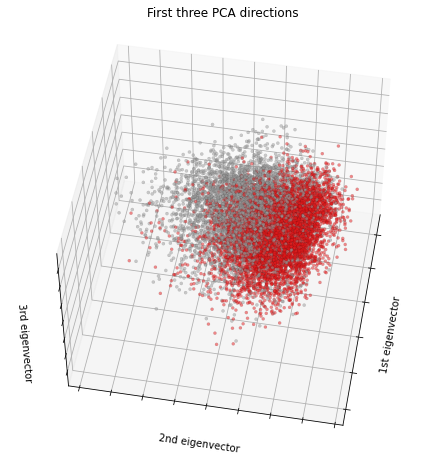

In [104]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-130, azim=170)
X_reduced = PCA(n_components=3).fit_transform(x_train)
ax.scatter(
    X_reduced[:, 0],
    X_reduced[:, 1],
    X_reduced[:, 2],
    c=y_train,
    edgecolor="k",
    linewidth=0.1,
    cmap=plt.cm.Set1,
    s=10,
    alpha=0.5
)

#     edgecolor="k",
ax.set_title("First three PCA directions")
ax.set_xlabel("1st eigenvector")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector")
ax.w_zaxis.set_ticklabels([])

plt.show()

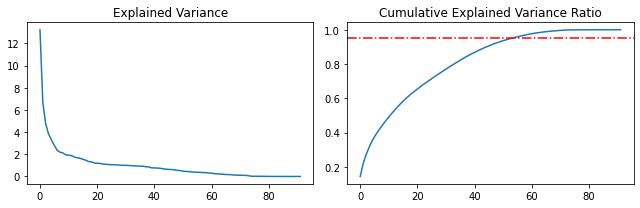

In [105]:
pca = PCA()
pca.fit_transform(x_train)
fig, axes = plt.subplots(1, 2, figsize=(9, 3))
axes[0].plot(pca.explained_variance_);
axes[0].set_title('Explained Variance')
axes[1].plot(np.cumsum(pca.explained_variance_ratio_));
axes[1].axhline(y=0.95, c='r', ls='-.')
axes[1].set_title('Cumulative Explained Variance Ratio')
plt.tight_layout()

### Feature Importance

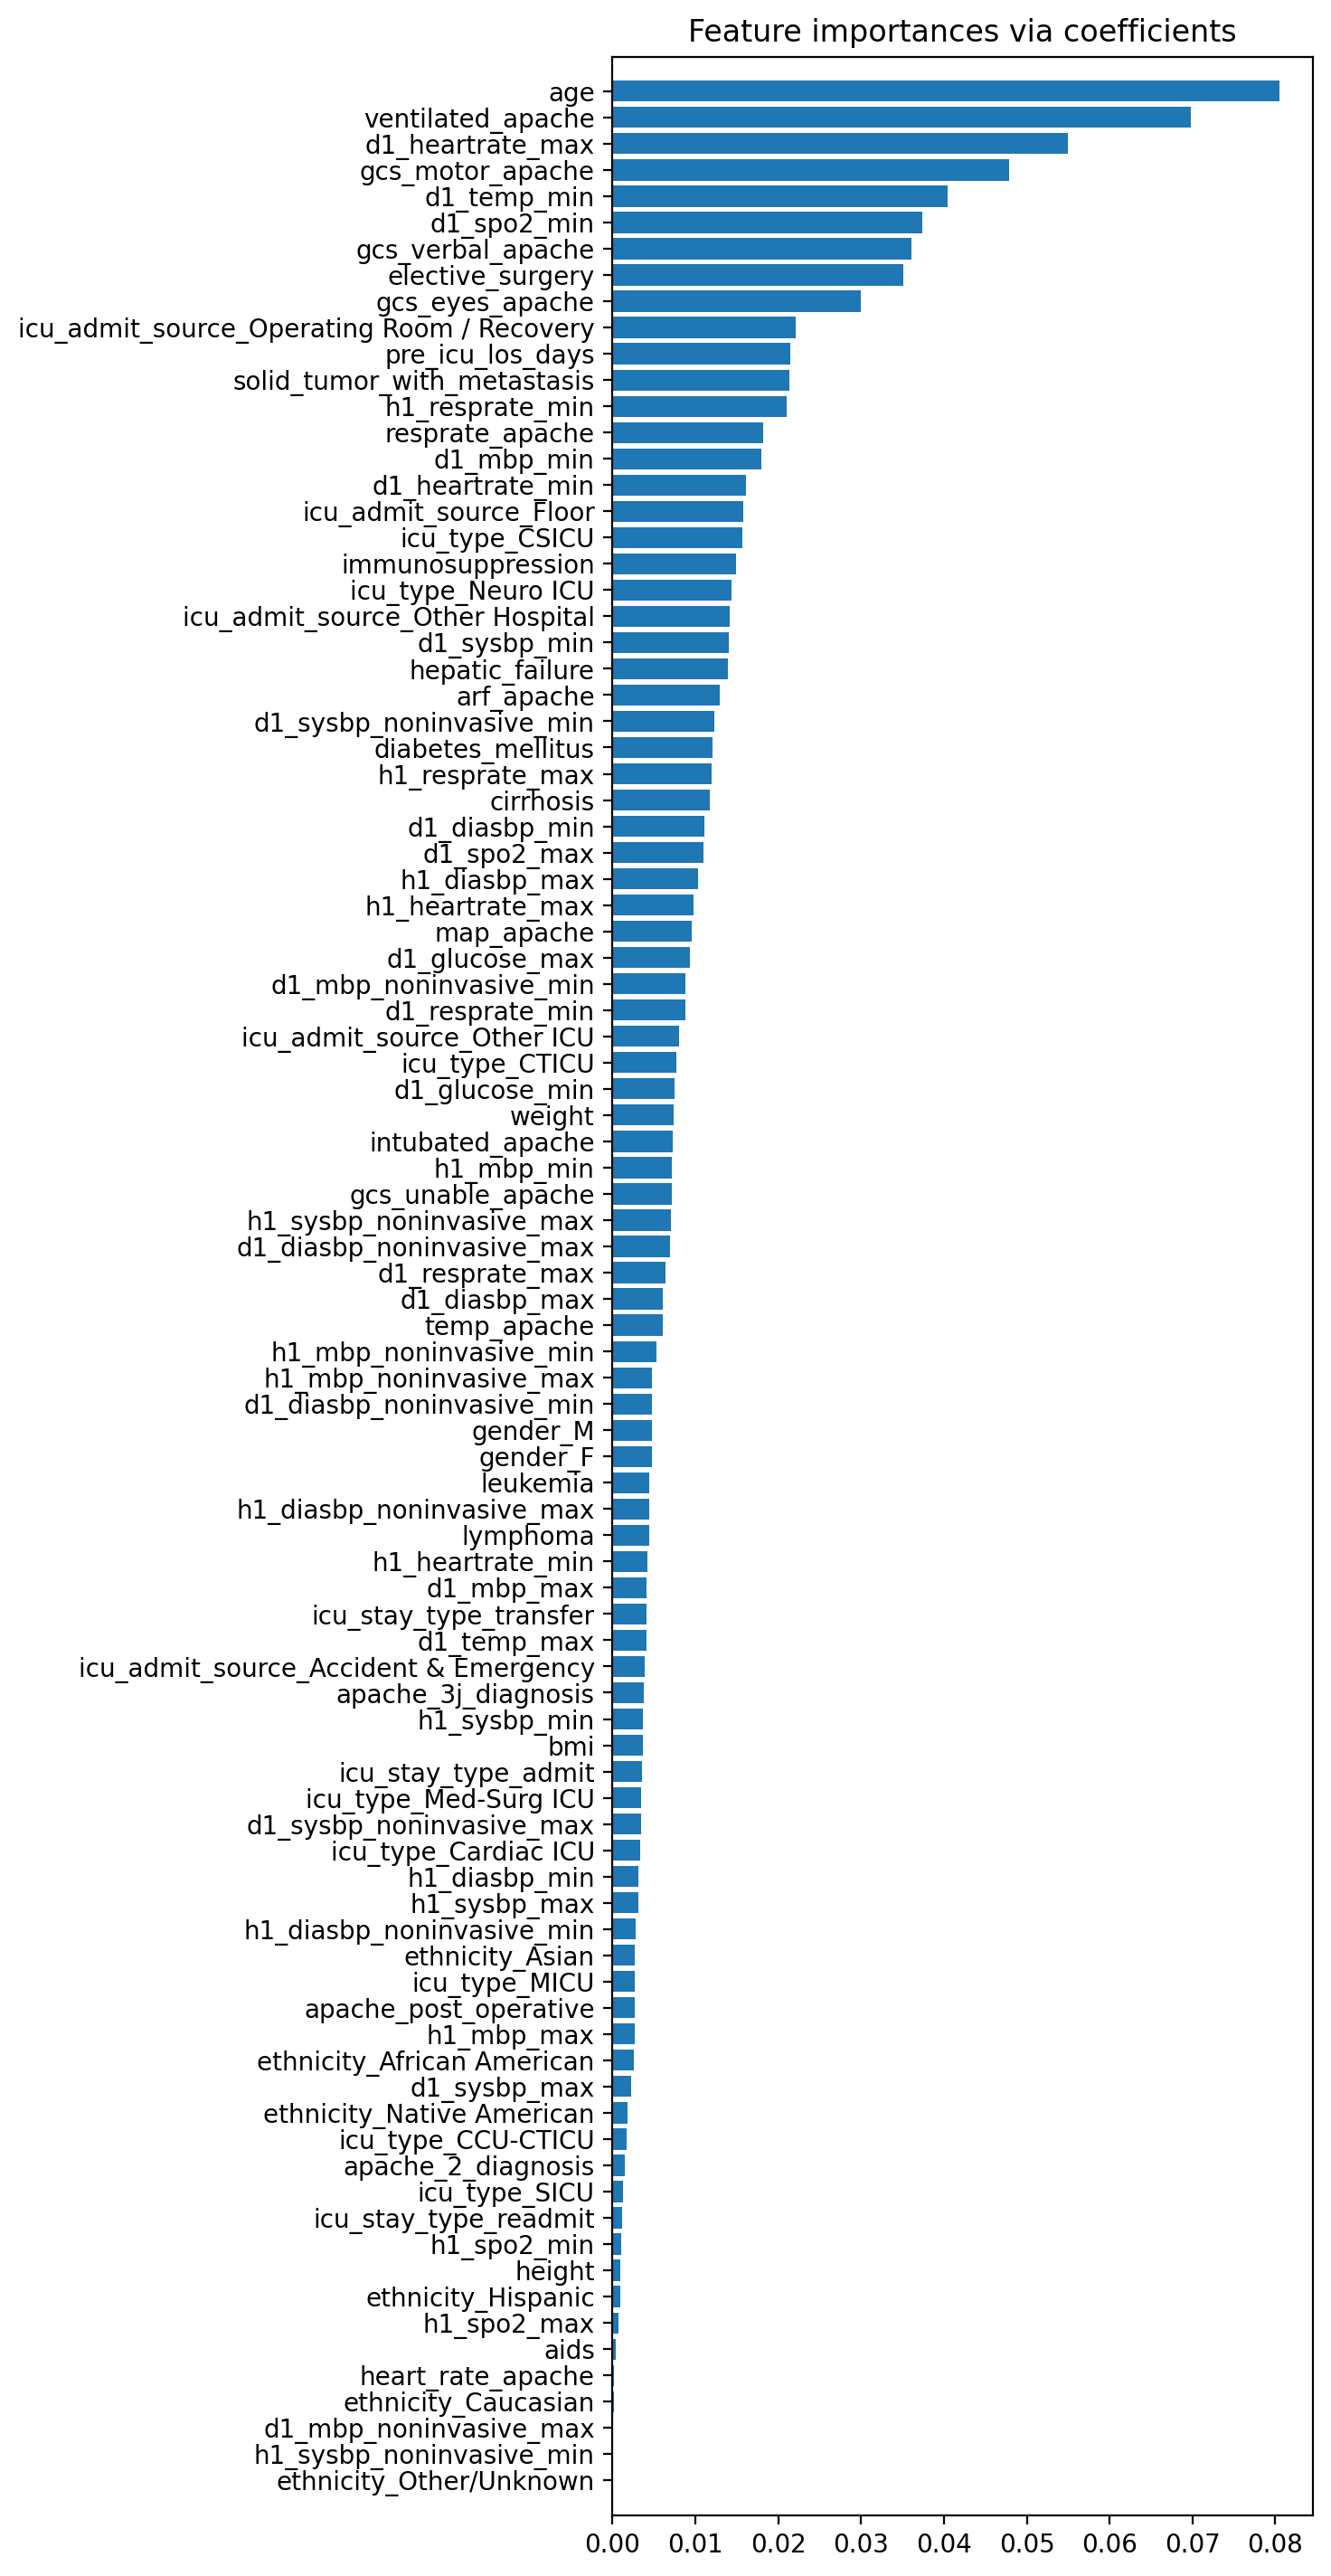

In [118]:
from sklearn.linear_model import RidgeCV

plt.figure(figsize=(5, 18), dpi=200)
ridge = RidgeCV(alphas=np.logspace(-6, 6, num=5)).fit(x_train, y_train)

feat_importance = pd.DataFrame({'feature_names': x_train.columns, 
               'importance': np.abs(ridge.coef_)})

feat_importance = feat_importance.sort_values('importance', ascending=True)

plt.barh(width=feat_importance.importance, y=feat_importance.feature_names)
plt.margins(y=0.01)
plt.title("Feature importances via coefficients")
plt.show()

## Part II: Training models

### K-Nearest Neighbors
First, we use grid search cross validation to find the optimal hyperparameter.

In [119]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

knn_search = KNeighborsClassifier()

param_grid = {'n_neighbors': np.arange(1, 40)}
knn_gscv = GridSearchCV(knn_search, param_grid, cv=5)
knn_gscv.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39])})

The optimal hyperparamater found using CV is {'n_neighbors': 39} nearest neighbors.


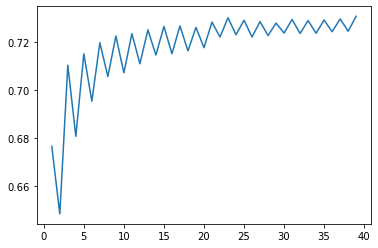

In [120]:
print("The optimal hyperparamater found using CV is %s nearest neighbors." % knn_gscv.best_params_)
plt.plot(knn_gscv.cv_results_['param_n_neighbors'].data, knn_gscv.cv_results_['mean_test_score'])

In [121]:
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.metrics import accuracy_score

knn = KNN(n_neighbors=39)
knn.fit(x_train, y_train)
        
accuracy_score(knn.predict(x_test), y_test)

0.7447883765003158

### Tree-based models
First, a simple descision tree model.

In [123]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(criterion="entropy")
tree.fit(x_train, y_train)

y_predicted = tree.predict(x_test)
accuracy_score(y_test, y_predicted)

0.6942514213518636

Next, a random forest ensemble method.

In [128]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

forest = RandomForestClassifier(n_estimators=60)
forest.fit(x_train, y_train)

y_predicted = forest.predict(x_test)
accuracy_score(y_test, y_predicted)

0.7842703727100442

### Logistic Regression

In [145]:
# Select hyperparamaters using grid search with cross validation
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

logistic = LogisticRegression(max_iter=10000)

grid_values = {'penalty': ['none','l1','l2'], 'C': [0.001,0.01,0.1,1,10,100,1000]}
gscv = GridSearchCV(logistic, param_grid=grid_values, cv=5)

gscv.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=10000),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'penalty': ['none', 'l1', 'l2']})

In [147]:
print("The optimal paramaters using cross-validation grid search is %s penalty \n using a regularization strength of %f." % (gscv.best_params_['penalty'], gscv.best_params_['C']) ) 

The optimal paramaters using cross-validation grid search is l2 penalty 
 using a regularization strength of 0.100000.


In [136]:
from sklearn.linear_model import LogisticRegression
logistic = LogisticRegression(max_iter=1000, penalty='l2', C=0.01)
logistic.fit(x_train, y_train)

y_predicted = logistic.predict(x_test)
accuracy_score(y_test, y_predicted)

0.7735312697409981

### Naive Baysian
Gausian Naive Baysian: likelihood of the features is assumed to be Gaussian

In [137]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(x_train, y_train)

y_predicted = gnb.predict(x_test)
accuracy_score(y_test, y_predicted)

0.7391029690461149

### Support Vector Machine (SVM)

In [141]:
from sklearn.svm import SVC
svm = SVC(kernel='poly', probability=True)
svm.fit(x_train, y_train)

y_predicted = svm.predict(x_test)
accuracy_score(y_test, y_predicted)

0.7650031585596968

## Part III: Evaluation

### ROC Curves and AOC

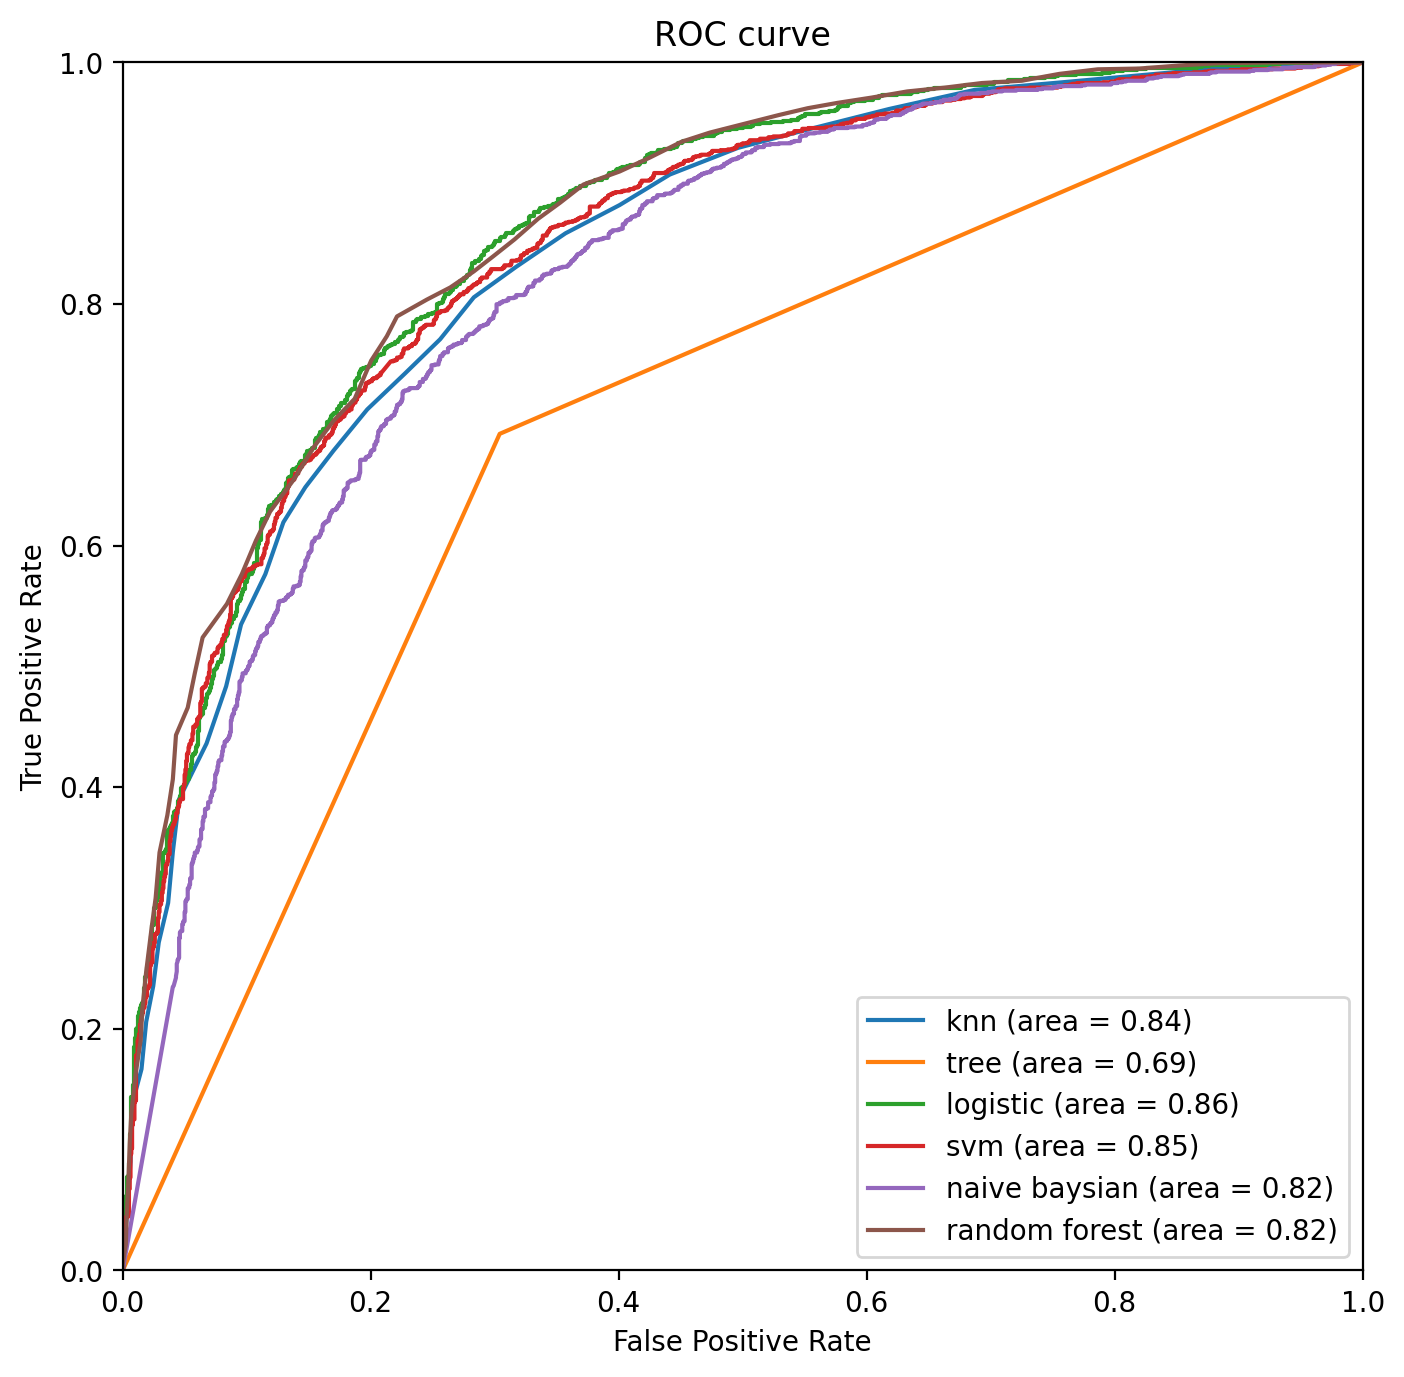

In [143]:
from sklearn.metrics import roc_curve, auc
y_knn   = knn.predict_proba(x_test)
y_tree  = tree.predict_proba(x_test)
y_logistic  = logistic.predict_proba(x_test)
y_svm  = svm.predict_proba(x_test)
y_gnb  = gnb.predict_proba(x_test)
y_forest  = forest.predict_proba(x_test)

curve_knn    = roc_curve(y_test, y_knn[:, 1])
curve_tree   = roc_curve(y_test, y_tree[:, 1])
curve_logistic   = roc_curve(y_test, y_logistic[:, 1])
curve_svm   = roc_curve(y_test, y_svm[:, 1])
curve_gnb   = roc_curve(y_test, y_gnb[:, 1])
curve_forest   = roc_curve(y_test, y_forest[:, 1])

# Compute Area Under the Curve
auc_knn    = auc(curve_knn[0], curve_knn[1])
auc_tree   = auc(curve_tree[0], curve_tree[1])
auc_logistic  = auc(curve_logistic[0], curve_logistic[1])
auc_svm  = auc(curve_svm[0], curve_svm[1])
auc_gnb  = auc(curve_gnb[0], curve_gnb[1])
auc_forest = auc(curve_forest[0], curve_forest[1])

plt.figure(figsize=(8, 8), dpi=200)

plt.plot(curve_knn[0], curve_knn[1], label='knn (area = %0.2f)'% auc_knn)
plt.plot(curve_tree[0], curve_tree[1], label='tree (area = %0.2f)' % auc_tree)
plt.plot(curve_logistic[0], curve_logistic[1], label='logistic (area = %0.2f)' % auc_logistic)
plt.plot(curve_svm[0], curve_svm[1], label='svm (area = %0.2f)' % auc_svm)
plt.plot(curve_gnb[0], curve_gnb[1], label='naive baysian (area = %0.2f)' % auc_gnb)
plt.plot(curve_forest[0], curve_forest[1], label='random forest (area = %0.2f)' % auc_gnb)


plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve');

plt.legend();